In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
from prophet.make_holidays import make_holidays_df
from itertools import product
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from prophet.diagnostics import cross_validation, performance_metrics


Importing plotly failed. Interactive plots will not work.


In [21]:
# read the data
df = pd.read_csv('bitcoin_price_sentiment_addmean.csv')

# make sure the date is in datetime format
df['date'] = pd.to_datetime(df['date'])
df['rolling_mean_7'] = df['Close'].rolling(window=7).mean()
df['rolling_std_7'] = df['Close'].rolling(window=7).std()
df = df.dropna()
print(df.head())

# prepare the dataframe for prophet
prophet_df = df[['date', 'Close']].rename(columns={'date': 'ds', 'Close': 'y'})

# prophet_df = df[['date', 'Close', 'sentiment_scores']].rename(columns={'date': 'ds', 'Close': 'y'})

# add the features to the dataframe
# features = ['Open', 'High', 'Low', 'Volume', 'sentiment_scores']

features = ['sentiment_scores', 'rolling_mean_7', 'rolling_std_7']

# standardize the features
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# add the features to the dataframe
for feature in features:
    prophet_df[feature] = df[feature]

# split the data into train and test
train_df, test_df = train_test_split(prophet_df, test_size=0.2, shuffle=False)

print(train_df.head())
print(test_df.tail())

         date  Open  High   Low  Close  Volume  sentiment_scores  \
6  2012-01-07  6.80  6.80  6.80   6.80     0.0          0.201493   
7  2012-01-08  6.90  6.90  6.90   6.90     0.0          0.201493   
8  2012-01-09  6.48  6.48  6.48   6.48     0.0          0.201493   
9  2012-01-10  7.10  7.10  7.10   7.10     0.0          0.201493   
10 2012-01-11  7.00  7.00  7.00   7.00     0.0          0.201493   

    rolling_mean_7  rolling_std_7  
6         5.760000       0.775435  
7         6.054286       0.758812  
8         6.265714       0.607120  
9         6.524286       0.497924  
10        6.728571       0.291858  
           ds     y  sentiment_scores  rolling_mean_7  rolling_std_7
6  2012-01-07  6.80      2.093275e-15       -0.748038      -0.632641
7  2012-01-08  6.90      2.093275e-15       -0.748023      -0.632663
8  2012-01-09  6.48      2.093275e-15       -0.748012      -0.632865
9  2012-01-10  7.10      2.093275e-15       -0.747998      -0.633011
10 2012-01-11  7.00      2.093

In [ ]:

# param_grid = {
#         'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#         'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
#         'seasonality_mode': ['additive', 'multiplicative'],
#         'yearly_seasonality': [True, False],
#         'weekly_seasonality': [True, False],
#         'daily_seasonality': [True, False]
#     }
# results = []
# # 生成所有参数组合
# param_combinations = [dict(zip(param_grid.keys(), v)) 
#                     for v in product(param_grid.values())]

# for params in param_combinations:
#     if params['growth'] == 'logistic':
#         train_df = train_df.copy()
#         train_df['cap'] = self.df['cap']
#         train_df['floor'] = self.df['floor']
#     else:
#         train_df = self.train_df.copy()
    
#     model.fit(train_df)
    
#     # 预测
#     if params['growth'] == 'logistic':
#         future = model.make_future_dataframe(periods=len(self.test_df))
#         future['cap'] = self.df['cap'].iloc[0]
#         future['floor'] = self.df['floor'].iloc[0]
#     else:
#         future = model.make_future_dataframe(periods=len(self.test_df))
#     model = Prophet(params)
#     model.fit(train_df)
    
#     # 预测
#     future = model.make_future_dataframe(periods=len(test_df))
#     forecast = model.predict(future)
    
#     # 评估
#     test_predictions = forecast['yhat'][-len(test_df):]
#     metrics = _calculate_metrics(test_df['y'], test_predictions)
    
#     results.append({
#         'params': params,
#         'metrics': metrics
#     })

# # 按MAPE排序
# results.sort(key=lambda x: x['metrics']['MAPE'])
# best_params = results[0]['params']

In [6]:
from itertools import product

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'yearly_seasonality': [True, False],
    'weekly_seasonality': [True, False],
    'daily_seasonality': [True, False]
}
param_combinations = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

best_params = None
best_mape = float('inf')
best_mae = float('inf')

for params in param_combinations:
    model = Prophet(**params)
    for feature in features:
        model.add_regressor(feature)
    model.fit(train_df)
    future = test_df[['ds', 'sentiment_scores', 'rolling_mean_7', 'rolling_std_7']]
    forecast = model.predict(future)
    # mape = np.mean(np.abs((test_df['y'] - forecast['yhat']) / test_df['y'])) * 100

    # acual value
    y_true = test_df['y'].values  
    # predicted value
    y_pred = forecast['yhat'].values 
    mask = y_true != 0
    # compute the mean absolute percentage error (MAPE)
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    # compute the mean absolute error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    print(params, mape)
    if mape < best_mape:
        best_mape = mape
        best_params = params
        best_mae = mae

print(best_params)
print(best_mape)
print(best_mae)

15:16:00 - cmdstanpy - INFO - Chain [1] start processing
15:16:00 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True} 2.78469142220127


15:16:01 - cmdstanpy - INFO - Chain [1] start processing
15:16:01 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False} 2.786632743154648


15:16:02 - cmdstanpy - INFO - Chain [1] start processing
15:16:03 - cmdstanpy - INFO - Chain [1] done processing
15:16:03 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True} 2.783686366642734


15:16:03 - cmdstanpy - INFO - Chain [1] done processing
15:16:04 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False} 2.780205143288217


15:16:04 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True} 2.739664409646695


15:16:05 - cmdstanpy - INFO - Chain [1] start processing
15:16:05 - cmdstanpy - INFO - Chain [1] done processing
15:16:05 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False} 2.7425858847189746


15:16:06 - cmdstanpy - INFO - Chain [1] done processing
15:16:06 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True} 2.7369204704840486


15:16:06 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False} 2.7375215353690012


15:16:07 - cmdstanpy - INFO - Chain [1] start processing
15:16:07 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True} 2.9252658409110057


15:16:08 - cmdstanpy - INFO - Chain [1] start processing
15:16:09 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False} 3.253574456657792


15:16:10 - cmdstanpy - INFO - Chain [1] start processing
15:16:10 - cmdstanpy - INFO - Chain [1] done processing
15:16:11 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True} 2.8127012653840753


15:16:11 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False} 3.3495165390903416


15:16:11 - cmdstanpy - INFO - Chain [1] start processing
15:16:12 - cmdstanpy - INFO - Chain [1] done processing
15:16:12 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True} 2.954216845875462


15:16:13 - cmdstanpy - INFO - Chain [1] done processing
15:16:13 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False} 3.1528922564746953


15:16:13 - cmdstanpy - INFO - Chain [1] done processing
15:16:13 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True} 2.906404356589933


15:16:14 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False} 2.967671058280102


15:16:14 - cmdstanpy - INFO - Chain [1] start processing
15:16:15 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True} 2.7836749093091306


15:16:15 - cmdstanpy - INFO - Chain [1] start processing
15:16:16 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False} 2.786455515014484


15:16:16 - cmdstanpy - INFO - Chain [1] start processing
15:16:17 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True} 2.7801757602147315


15:16:17 - cmdstanpy - INFO - Chain [1] start processing
15:16:18 - cmdstanpy - INFO - Chain [1] done processing
15:16:18 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False} 2.7826702224654367


15:16:18 - cmdstanpy - INFO - Chain [1] done processing
15:16:19 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True} 2.734249856503514


15:16:19 - cmdstanpy - INFO - Chain [1] done processing
15:16:20 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False} 2.7386519787856045


15:16:20 - cmdstanpy - INFO - Chain [1] done processing
15:16:20 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True} 2.7334103359506066


15:16:21 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False} 2.7375215353690012


15:16:21 - cmdstanpy - INFO - Chain [1] start processing
15:16:22 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True} 2.8015050519500293


15:16:22 - cmdstanpy - INFO - Chain [1] start processing
15:16:23 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False} 3.084350204272976


15:16:23 - cmdstanpy - INFO - Chain [1] start processing
15:16:24 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True} 2.831752376963934


15:16:24 - cmdstanpy - INFO - Chain [1] start processing
15:16:25 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False} 3.228477637475455


15:16:25 - cmdstanpy - INFO - Chain [1] start processing
15:16:25 - cmdstanpy - INFO - Chain [1] done processing
15:16:26 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True} 2.9187347970027204


15:16:26 - cmdstanpy - INFO - Chain [1] done processing
15:16:27 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False} 3.247396680742999


15:16:27 - cmdstanpy - INFO - Chain [1] done processing
15:16:27 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True} 2.7615411664410705


15:16:28 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False} 2.967671058280102


15:16:28 - cmdstanpy - INFO - Chain [1] start processing
15:16:29 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True} 2.782540255018685


15:16:29 - cmdstanpy - INFO - Chain [1] start processing
15:16:30 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False} 2.78289183223941


15:16:30 - cmdstanpy - INFO - Chain [1] start processing
15:16:31 - cmdstanpy - INFO - Chain [1] done processing
15:16:31 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True} 2.780939994586747


15:16:31 - cmdstanpy - INFO - Chain [1] done processing
15:16:32 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False} 2.7849426922998277


15:16:32 - cmdstanpy - INFO - Chain [1] done processing
15:16:32 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True} 2.7378488424904126


15:16:33 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False} 2.7352902862410264


15:16:33 - cmdstanpy - INFO - Chain [1] start processing
15:16:33 - cmdstanpy - INFO - Chain [1] done processing
15:16:34 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True} 2.7339626727954167


15:16:34 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False} 2.7375215353690012


15:16:35 - cmdstanpy - INFO - Chain [1] start processing
15:16:35 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True} 3.2372130846215175


15:16:36 - cmdstanpy - INFO - Chain [1] start processing
15:16:36 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False} 3.410774648218852


15:16:37 - cmdstanpy - INFO - Chain [1] start processing
15:16:37 - cmdstanpy - INFO - Chain [1] done processing
15:16:38 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True} 2.8075057982087386


15:16:38 - cmdstanpy - INFO - Chain [1] done processing
15:16:38 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False} 3.349995122248703


15:16:39 - cmdstanpy - INFO - Chain [1] done processing
15:16:39 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True} 2.861916179719333


15:16:40 - cmdstanpy - INFO - Chain [1] done processing
15:16:40 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False} 3.2887305408530785


15:16:40 - cmdstanpy - INFO - Chain [1] done processing
15:16:41 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True} 2.906909505541473


15:16:41 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False} 2.967671058280102


15:16:42 - cmdstanpy - INFO - Chain [1] start processing
15:16:43 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True} 2.8087592349523773


15:16:43 - cmdstanpy - INFO - Chain [1] start processing
15:16:44 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False} 2.809439237826821


15:16:44 - cmdstanpy - INFO - Chain [1] start processing
15:16:45 - cmdstanpy - INFO - Chain [1] done processing
15:16:45 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True} 2.810479919895287


15:16:46 - cmdstanpy - INFO - Chain [1] done processing
15:16:46 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False} 2.8065786008444036


15:16:47 - cmdstanpy - INFO - Chain [1] done processing
15:16:47 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True} 2.7738742275815054


15:16:48 - cmdstanpy - INFO - Chain [1] done processing
15:16:48 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False} 2.770070095813855


15:16:49 - cmdstanpy - INFO - Chain [1] done processing
15:16:49 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True} 2.7537104131529584


15:16:50 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False} 2.764352943395796


15:16:50 - cmdstanpy - INFO - Chain [1] start processing
15:16:51 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True} 3.9160613567039766


15:16:52 - cmdstanpy - INFO - Chain [1] start processing
15:16:53 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False} 3.971882681747605


15:16:54 - cmdstanpy - INFO - Chain [1] start processing
15:16:55 - cmdstanpy - INFO - Chain [1] done processing
15:16:55 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True} 4.016521560374549


15:16:56 - cmdstanpy - INFO - Chain [1] done processing
15:16:57 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False} 3.9618100369016176


15:16:58 - cmdstanpy - INFO - Chain [1] done processing
15:16:58 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True} 3.3833772585527533


15:17:00 - cmdstanpy - INFO - Chain [1] done processing
15:17:00 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False} 3.980190149725365


15:17:01 - cmdstanpy - INFO - Chain [1] done processing
15:17:01 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True} 3.800254726083671


15:17:02 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False} 4.0143544086356435


15:17:02 - cmdstanpy - INFO - Chain [1] start processing
15:17:03 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True} 2.8026079863863735


15:17:03 - cmdstanpy - INFO - Chain [1] start processing
15:17:04 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False} 2.806008035326126


15:17:05 - cmdstanpy - INFO - Chain [1] start processing
15:17:05 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True} 2.7995458404203926


15:17:06 - cmdstanpy - INFO - Chain [1] start processing
15:17:06 - cmdstanpy - INFO - Chain [1] done processing
15:17:07 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False} 2.7996061232284797


15:17:07 - cmdstanpy - INFO - Chain [1] done processing
15:17:08 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True} 2.767456103594682


15:17:08 - cmdstanpy - INFO - Chain [1] done processing
15:17:09 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False} 2.768978085795863


15:17:09 - cmdstanpy - INFO - Chain [1] done processing
15:17:09 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True} 2.7731149195221674


15:17:10 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False} 2.764352943395796


15:17:11 - cmdstanpy - INFO - Chain [1] start processing
15:17:12 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True} 3.8898538822559803


15:17:12 - cmdstanpy - INFO - Chain [1] start processing
15:17:13 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False} 3.995479061455693


15:17:14 - cmdstanpy - INFO - Chain [1] start processing
15:17:15 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True} 3.973475937306519


15:17:15 - cmdstanpy - INFO - Chain [1] start processing
15:17:16 - cmdstanpy - INFO - Chain [1] done processing
15:17:17 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False} 4.001268924492485


15:17:18 - cmdstanpy - INFO - Chain [1] done processing
15:17:18 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True} 3.35775565489841


15:17:20 - cmdstanpy - INFO - Chain [1] done processing
15:17:20 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False} 4.003727853494462


15:17:21 - cmdstanpy - INFO - Chain [1] done processing
15:17:21 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True} 3.758542895426989


15:17:22 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False} 4.0143544086356435


15:17:22 - cmdstanpy - INFO - Chain [1] start processing
15:17:23 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True} 2.814929909785074


15:17:24 - cmdstanpy - INFO - Chain [1] start processing
15:17:24 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False} 2.804544900236899


15:17:25 - cmdstanpy - INFO - Chain [1] start processing
15:17:26 - cmdstanpy - INFO - Chain [1] done processing
15:17:26 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True} 2.8066356994586936


15:17:27 - cmdstanpy - INFO - Chain [1] done processing
15:17:27 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False} 2.8148350733349385


15:17:28 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True} 2.7760794801593116


15:17:28 - cmdstanpy - INFO - Chain [1] start processing
15:17:29 - cmdstanpy - INFO - Chain [1] done processing
15:17:29 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False} 2.777279231078241


15:17:29 - cmdstanpy - INFO - Chain [1] done processing
15:17:30 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True} 2.7381156771813417


15:17:30 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False} 2.764352943395796


15:17:31 - cmdstanpy - INFO - Chain [1] start processing
15:17:32 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True} 3.909494458703887


15:17:32 - cmdstanpy - INFO - Chain [1] start processing
15:17:34 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False} 4.0368516516167405


15:17:34 - cmdstanpy - INFO - Chain [1] start processing
15:17:36 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True} 3.47341271013413


15:17:36 - cmdstanpy - INFO - Chain [1] start processing
15:17:37 - cmdstanpy - INFO - Chain [1] done processing
15:17:38 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False} 4.027346191355621


15:17:39 - cmdstanpy - INFO - Chain [1] done processing
15:17:39 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True} 3.8017977018828697


15:17:41 - cmdstanpy - INFO - Chain [1] done processing
15:17:42 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False} 3.9862257809907238


15:17:43 - cmdstanpy - INFO - Chain [1] done processing
15:17:44 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True} 3.8481050244958133


15:17:45 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False} 4.0143544086356435


15:17:45 - cmdstanpy - INFO - Chain [1] start processing
15:17:47 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True} 2.9574578225819703


15:17:48 - cmdstanpy - INFO - Chain [1] start processing
15:17:49 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False} 2.964402809159009


15:17:50 - cmdstanpy - INFO - Chain [1] start processing
15:17:52 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True} 2.9794979959424515


15:17:52 - cmdstanpy - INFO - Chain [1] start processing
15:17:54 - cmdstanpy - INFO - Chain [1] done processing
15:17:54 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False} 2.9578967910876544


15:17:55 - cmdstanpy - INFO - Chain [1] done processing
15:17:56 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True} 2.861400080328822


15:17:57 - cmdstanpy - INFO - Chain [1] done processing
15:17:57 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False} 2.867728063978721


15:17:59 - cmdstanpy - INFO - Chain [1] done processing
15:17:59 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True} 2.8503405841084413


15:18:00 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False} 2.875931213595839


15:18:00 - cmdstanpy - INFO - Chain [1] start processing
15:18:01 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True} 3.8010157259551023


15:18:01 - cmdstanpy - INFO - Chain [1] start processing
15:18:02 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False} 4.2385798642747226


15:18:02 - cmdstanpy - INFO - Chain [1] start processing
15:18:03 - cmdstanpy - INFO - Chain [1] done processing
15:18:04 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True} 3.7646535194145634


15:18:04 - cmdstanpy - INFO - Chain [1] done processing
15:18:05 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False} 4.211005894253157


15:18:05 - cmdstanpy - INFO - Chain [1] done processing
15:18:05 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True} 4.1911809769456445


15:18:06 - cmdstanpy - INFO - Chain [1] done processing
15:18:06 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False} 4.464834644703275


15:18:08 - cmdstanpy - INFO - Chain [1] done processing
15:18:09 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True} 4.4963275409372345


15:18:09 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False} 4.441383094710525


15:18:10 - cmdstanpy - INFO - Chain [1] start processing
15:18:12 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True} 2.970757309766005


15:18:12 - cmdstanpy - INFO - Chain [1] start processing
15:18:14 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False} 2.9720509574096594


15:18:14 - cmdstanpy - INFO - Chain [1] start processing
15:18:15 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True} 2.943743314624819


15:18:16 - cmdstanpy - INFO - Chain [1] start processing
15:18:17 - cmdstanpy - INFO - Chain [1] done processing
15:18:17 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False} 2.9597898028362866


15:18:18 - cmdstanpy - INFO - Chain [1] done processing
15:18:19 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True} 2.8734312570413865


15:18:20 - cmdstanpy - INFO - Chain [1] done processing
15:18:20 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False} 2.8680396828972943


15:18:21 - cmdstanpy - INFO - Chain [1] done processing
15:18:22 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True} 2.8648579106577485


15:18:23 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False} 2.875931213595839


15:18:23 - cmdstanpy - INFO - Chain [1] start processing
15:18:24 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True} 3.80457499651717


15:18:24 - cmdstanpy - INFO - Chain [1] start processing
15:18:25 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False} 4.3062955771187035


15:18:26 - cmdstanpy - INFO - Chain [1] start processing
15:18:27 - cmdstanpy - INFO - Chain [1] done processing
15:18:27 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True} 4.108647606445721


15:18:28 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False} 4.391765370132635


15:18:28 - cmdstanpy - INFO - Chain [1] start processing
15:18:29 - cmdstanpy - INFO - Chain [1] done processing
15:18:29 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True} 3.049201530143522


15:18:30 - cmdstanpy - INFO - Chain [1] done processing
15:18:30 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False} 4.387065212563586


15:18:31 - cmdstanpy - INFO - Chain [1] done processing
15:18:32 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True} 4.3673264945608


15:18:32 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False} 4.441383094710525


15:18:33 - cmdstanpy - INFO - Chain [1] start processing
15:18:34 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True} 2.970977462484477


15:18:35 - cmdstanpy - INFO - Chain [1] start processing
15:18:36 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False} 2.9614701143924687


15:18:36 - cmdstanpy - INFO - Chain [1] start processing
15:18:38 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True} 2.941996761739741


15:18:39 - cmdstanpy - INFO - Chain [1] start processing
15:18:40 - cmdstanpy - INFO - Chain [1] done processing
15:18:41 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False} 2.9612596642062115


15:18:42 - cmdstanpy - INFO - Chain [1] done processing
15:18:42 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True} 2.8667480276253228


15:18:44 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False} 2.876189800074848


15:18:44 - cmdstanpy - INFO - Chain [1] start processing
15:18:46 - cmdstanpy - INFO - Chain [1] done processing
15:18:46 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True} 2.8640824967506147


15:18:47 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False} 2.875931213595839


15:18:48 - cmdstanpy - INFO - Chain [1] start processing
15:18:48 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True} 4.361193022887786


15:18:48 - cmdstanpy - INFO - Chain [1] start processing
15:18:49 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False} 4.258231690719545


15:18:50 - cmdstanpy - INFO - Chain [1] start processing
15:18:51 - cmdstanpy - INFO - Chain [1] done processing
15:18:52 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True} 4.271036204925615


15:18:53 - cmdstanpy - INFO - Chain [1] done processing
15:18:53 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False} 4.280908476894306


15:18:54 - cmdstanpy - INFO - Chain [1] done processing
15:18:54 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True} 3.7907589048810824


15:18:55 - cmdstanpy - INFO - Chain [1] done processing
15:18:55 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False} 4.332854125690196


15:18:56 - cmdstanpy - INFO - Chain [1] done processing
15:18:56 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True} 4.337660193651291


15:18:57 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False} 4.441383094710525
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True}
2.7334103359506066
1016.5393112143515


15:19:46 - cmdstanpy - INFO - Chain [1] start processing
15:19:46 - cmdstanpy - INFO - Chain [1] done processing


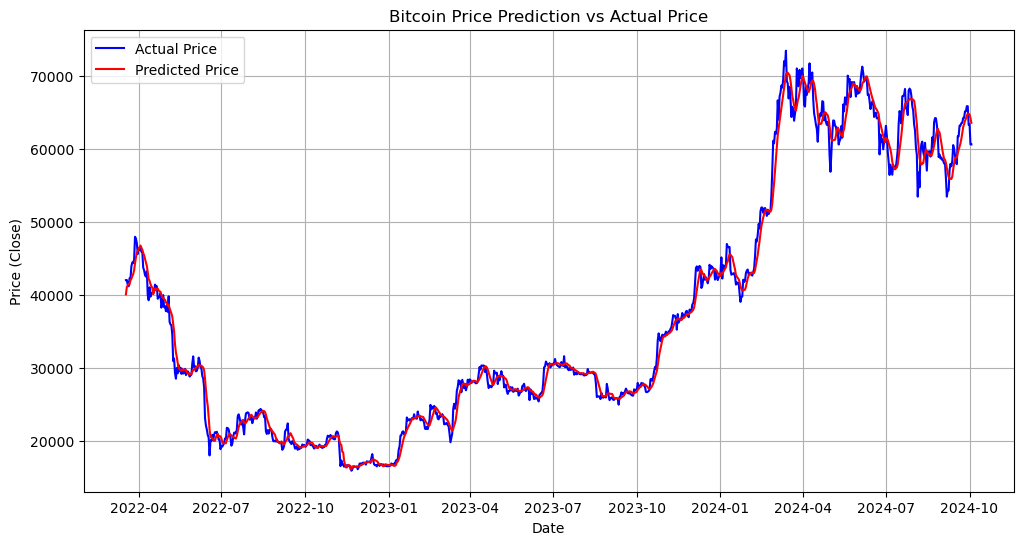

In [8]:
start_time = time.time()

# Initialize the Prophet model with tuned parameters and custom seasonality
# model = Prophet(
#     changepoint_prior_scale=0.01,
#     seasonality_prior_scale=1,
#     # holidays=holidays,
#     yearly_seasonality=True,
#     weekly_seasonality=False,
#     daily_seasonality=False
# )

# Initialize the Prophet model with best_params
model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    seasonality_mode=best_params['seasonality_mode'],
    yearly_seasonality=best_params['yearly_seasonality'],
    weekly_seasonality=best_params['weekly_seasonality'],
    daily_seasonality=best_params['daily_seasonality']
)


# create Prophet model
# model = Prophet()
prediction_period = 30

# add regressors
for feature in features:
    model.add_regressor(feature)

# train the model
model.fit(train_df)

# df_cv = cross_validation(model, initial='365.25 days', period='180 days', horizon='60 days')
# df_performance = performance_metrics(df_cv)

future = test_df[['ds', 'sentiment_scores', 'rolling_mean_7', 'rolling_std_7']]

# future = model.make_future_dataframe(periods=prediction_period)
# for feature in features:
#     future[feature] = df[feature].iloc[-1]

forecast = model.predict(future)


end_time = time.time()
runtime = end_time - start_time


# read the prediction result
forecast_filtered = forecast[['ds', 'yhat']]

# merge the prediction result with the actual price
# df_merged = pd.merge(forecast_filtered, prophet_df, on='ds', how='left')
df_merged = pd.merge(forecast_filtered, test_df, on='ds', how='left')


# plot the figure
plt.figure(figsize=(12, 6))

# plot the actual price line
plt.plot(df_merged['ds'], df_merged['y'], label='Actual Price', color='blue')

# plot the predicted price line
plt.plot(df_merged['ds'], df_merged['yhat'], label='Predicted Price', color='red')

# add the legend
plt.legend()
plt.title('Bitcoin Price Prediction vs Actual Price')
plt.xlabel('Date')
plt.ylabel('Price (Close)')
plt.grid(True)
plt.show()

In [9]:
import joblib

joblib.dump(model, 'prophet_model.pkl')


['prophet_model.pkl']

In [10]:
# compute the metrics
# acual value
y_true = test_df['y'].values  
# predicted value
y_pred = forecast['yhat'].values 

# compute the mean absolute error (MAE)
mae = mean_absolute_error(y_true, y_pred)

mask = y_true != 0
# compute the mean absolute percentage error (MAPE)
mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# compute the coefficient of determination (R^2)
r2 = r2_score(y_true, y_pred)

# print the metrics
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'Runtime: {runtime:.2f} seconds')


MAE: 1016.5393112143515
MAPE: 2.7334103359506066
Runtime: 0.77 seconds


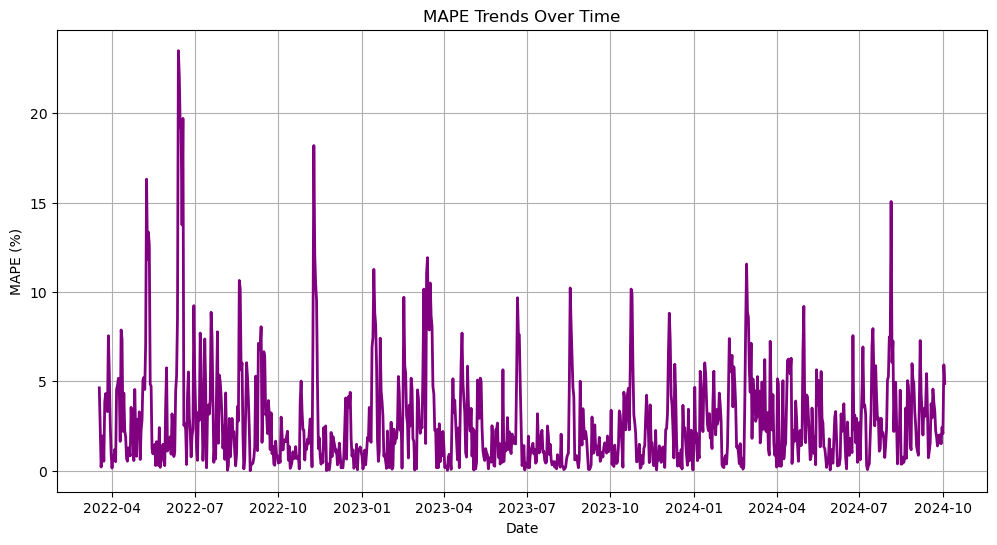

In [11]:
import numpy as np

# Calculate MAPE over time
mape_over_time = 100 * np.abs((y_true - y_pred) / y_true)

plt.figure(figsize=(12, 6))
plt.plot(test_df['ds'], mape_over_time, label='MAPE', color='purple', linestyle='-', linewidth=2)
plt.title('MAPE Trends Over Time')
plt.xlabel('Date')
plt.ylabel('MAPE (%)')
plt.grid(True)
plt.show()

In [18]:
import requests

def get_crypto_compare_data(start_date, end_date, api_key):
    url = 'https://min-api.cryptocompare.com/data/v2/histoday'
    params = {
        'fsym': 'BTC',
        'tsym': 'USD',
        'limit': 30,  # Set the maximum number of days to retrieve
        'toTs': end_date,
        'api_key': api_key  # Your API key
    }
    response = requests.get(url, params=params)
    data = response.json()

    if 'Data' in data and 'Data' in data['Data']:
        return pd.DataFrame(data['Data']['Data'])
    else:
        print("Error fetching data:", data)
        return None
    
# Assuming you have obtained the API key and set the start and end dates
api_key = 'your_api_key'
start_date = int(pd.Timestamp('2024-10-27').timestamp())
end_date = int(pd.Timestamp('2024-11-30').timestamp())

# Fetch historical price data
btc_data = get_crypto_compare_data(start_date, end_date, api_key)
from datetime import datetime as dt

# 将时间戳列转换为datetime格式，无法解析的时间戳将变为NaT
btc_data['bit_coin_date_time'] = pd.to_datetime(btc_data['time'], unit='s', errors='coerce')
# btc_data.to_csv('bitcoin_date_time_price.csv', index=False)
# 删除包含非法时间戳（NaT）的行
btc_data = btc_data.dropna(subset=['bit_coin_date_time'])
btc_data = btc_data.groupby(btc_data['bit_coin_date_time'].dt.date).tail(1)
btc_data['date'] = btc_data['bit_coin_date_time'].dt.strftime('%Y-%m-%d')
# btc_data = btc_data[['date', 'Open', 'High', 'Low', 'Close', 'Volume']]
# print(btc_data)

ds                  2024-10-03 00:00:00
y                               73468.0
sentiment_scores                 8.8205
rolling_mean_7                 2.966253
rolling_std_7                  5.614631
dtype: object
          ds         y
0 2024-10-28  69925.83
1 2024-10-29  72723.67
2 2024-10-30  72331.96
3 2024-10-31  70207.54
4 2024-11-01  69473.41


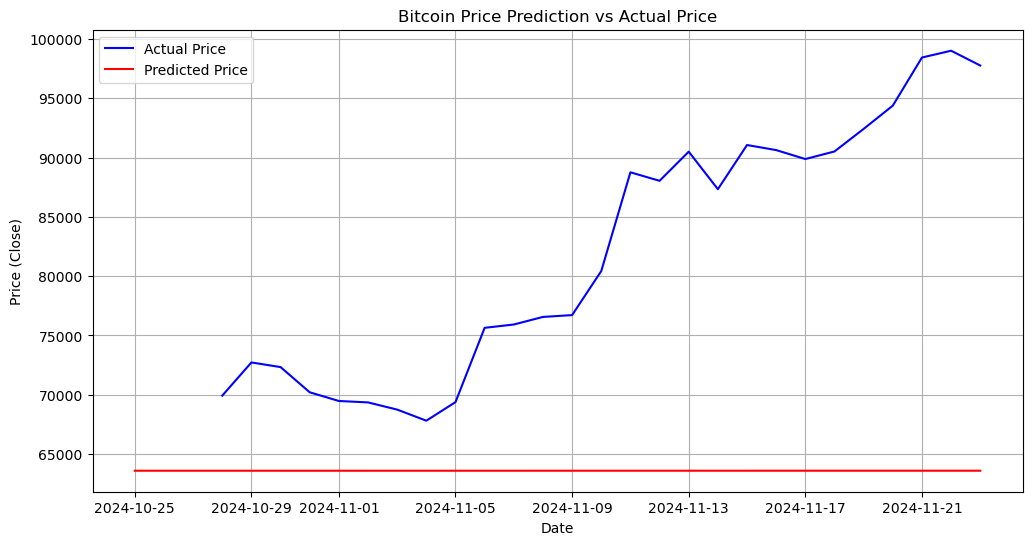

In [23]:
last_row = test_df.max()
print(last_row)

# make sure the date is in datetime format
btc_data['date'] = pd.to_datetime(btc_data['date'])

# prepare the dataframe for prophet
prophet_btc_future = btc_data[['date', 'close']].rename(columns={'date': 'ds', 'close': 'y'})
print(prophet_btc_future.head())
# print(prophet_btc_future)

start_date = '2024-10-25'  # 预测开始日期
end_date = '2024-11-30'  # 预测截止日期

# 创建未来30天的日期范围
# future_dates = model.make_future_dataframe(periods=prediction_period)
future_dates = pd.date_range(start=start_date, end=end_date)
future_df = pd.DataFrame({'ds': future_dates})
# print(future_dates)
# 为未来日期添加特征值
# 这里我们使用最后一个已知的值，你可能需要根据实际情况调整这个逻辑
for feature in features:
    future_df[feature] = df[feature].iloc[-1]
# 进行预测
forecast = model.predict(future_df)

# read the prediction result
forecast_filtered = forecast[['ds', 'yhat']]
# print(forecast_filtered)

# merge the prediction result with the actual price
# df_merged = pd.merge(forecast_filtered, prophet_df, on='ds', how='left')
df_merged = pd.merge(forecast_filtered, prophet_btc_future, on='ds', how='left')

# print(df_merged.head())

df_merged = df_merged[df_merged['ds'] > prophet_df['ds'].max()].head(prediction_period)


# plot the figure
plt.figure(figsize=(12, 6))

# plot the actual price line
plt.plot(df_merged['ds'], df_merged['y'], label='Actual Price', color='blue')

# plot the predicted price line
plt.plot(df_merged['ds'], df_merged['yhat'], label='Predicted Price', color='red')

# add the legend
plt.legend()
plt.title('Bitcoin Price Prediction vs Actual Price')
plt.xlabel('Date')
plt.ylabel('Price (Close)')
plt.grid(True)
plt.show()